In [1]:
pip install git+https://github.com/dr-aheydari/SoftAdapt.git

  Cloning https://github.com/dr-aheydari/SoftAdapt.git to /tmp/pip-req-build-nr6nkksr
  Running command git clone --filter=blob:none --quiet https://github.com/dr-aheydari/SoftAdapt.git /tmp/pip-req-build-nr6nkksr
  Resolved https://github.com/dr-aheydari/SoftAdapt.git to commit 5fc955f424052cc94824d7ba9d7e7ea564c8e254
  Preparing metadata (setup.py) ... done
  Created wheel for softadapt: filename=softadapt-0.0.5-py3-none-any.whl size=15183 sha256=3879931b0f6016fa2fae08aab7e615fcb3bade22233e4866a56072b7f535804f
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_d2b2cy/wheels/d1/be/a6/ec235953fe96a72a3a6b4da3fe87a8fd3e2a73ce6f347b1c43
Successfully built softadapt


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from cylinder_channel_geometry import *
from cylinder_channel_exact_solutions import *
from torch.optim.lr_scheduler import StepLR
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt
import torch.nn.init as init

In [3]:
# Set geometric parameters.

# Grid
grid_length_x = 10
grid_length_y = 5
grid_nr_xs = 100
grid_nr_ys = 50

# Cylinder
cylinder_radius = 1
cylinder_center = (0, 0)
nr_samples_on_cylinder = 100

make_plots = True

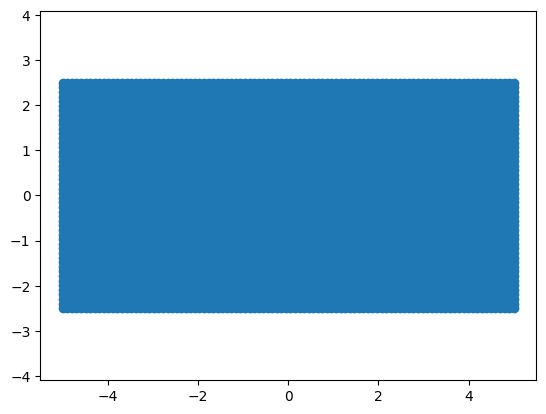

In [4]:
# Get grid.
grid = make_grid(
    x_length=grid_length_x,
    y_length=grid_length_y,
    nr_xs=grid_nr_xs,
    nr_ys=grid_nr_ys,
    make_plot=make_plots
)

In [5]:
# Get grid xs and ys.
xs, ys = grid

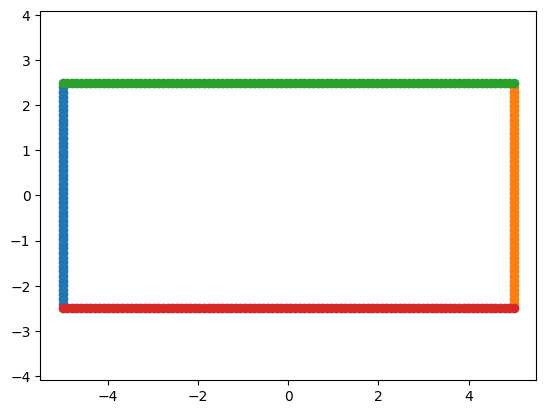

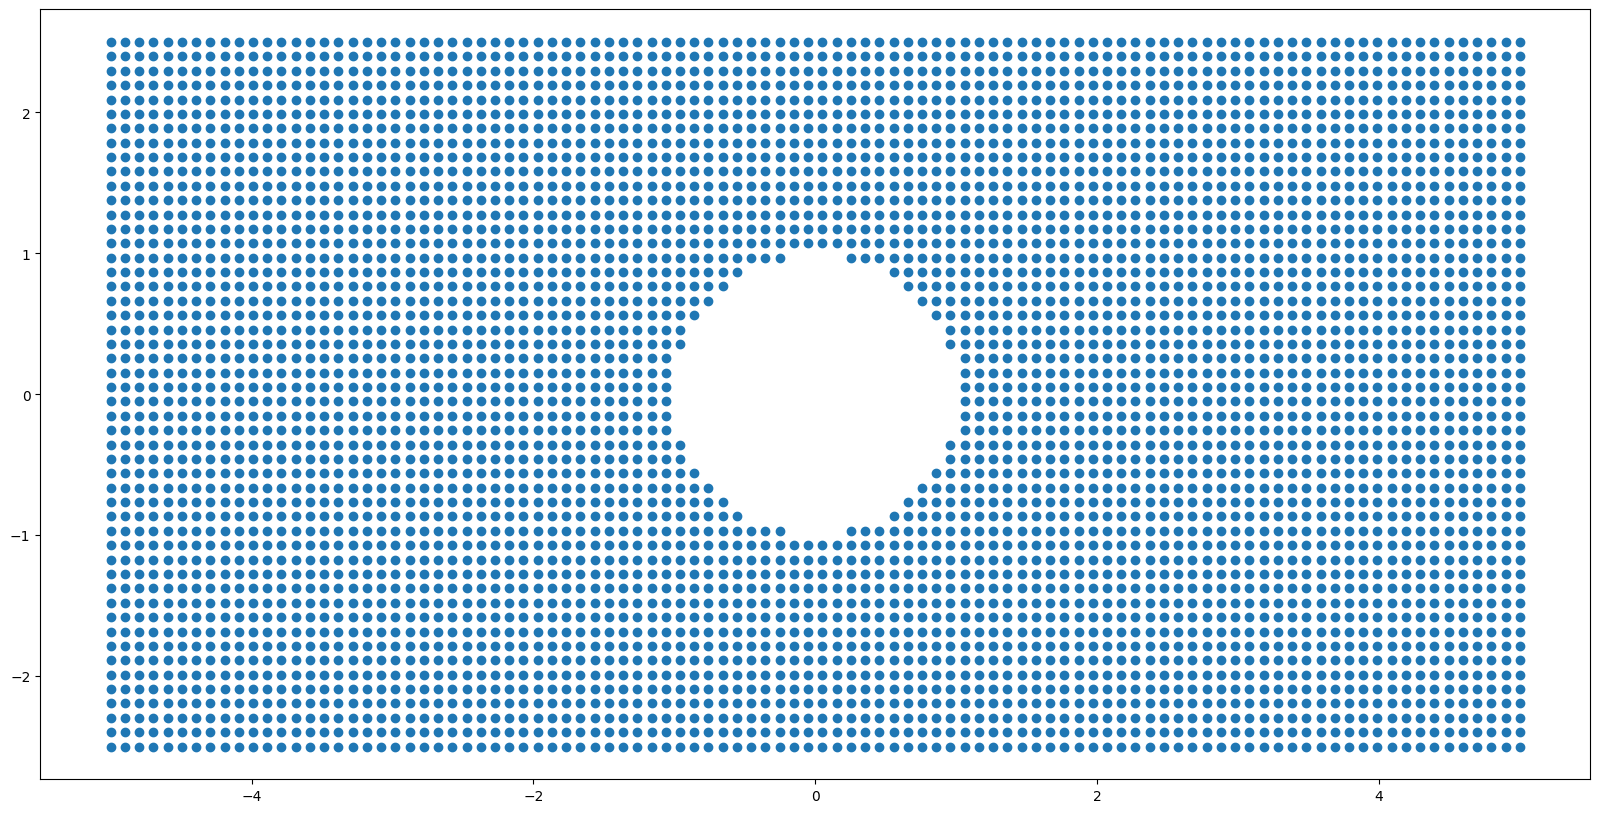

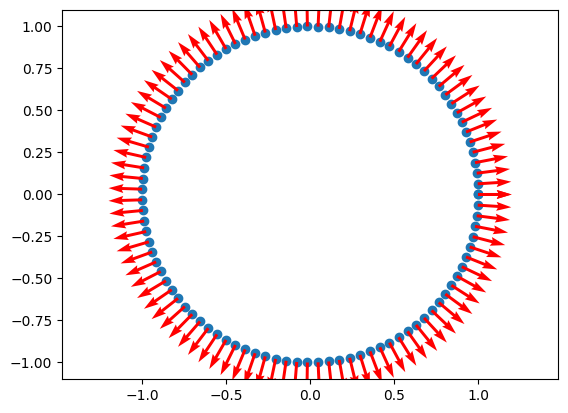

In [6]:
# Sample channel boundary.
inlet_xys, outlet_xys, left_wall_xys, right_wall_xys = sample_channel_boundary(grid, make_plots)

# Sample grid without cylinder.
channel_with_cylinder_xs, channel_with_cylinder_ys = exclude_cylinder_points(grid, make_plot=make_plots)

# Sample cylinder boundary.
cylinder_boundary_xs, cylinder_boundary_ys, cylinder_normals = sample_cylinder_boundary_and_compute_normals(
    cylinder_center,
    cylinder_radius,
    nr_samples_on_cylinder,
    make_plots,
)

# Convert to tensor.
cylinder_normals_tens = torch.tensor(cylinder_normals, dtype=torch.float32)

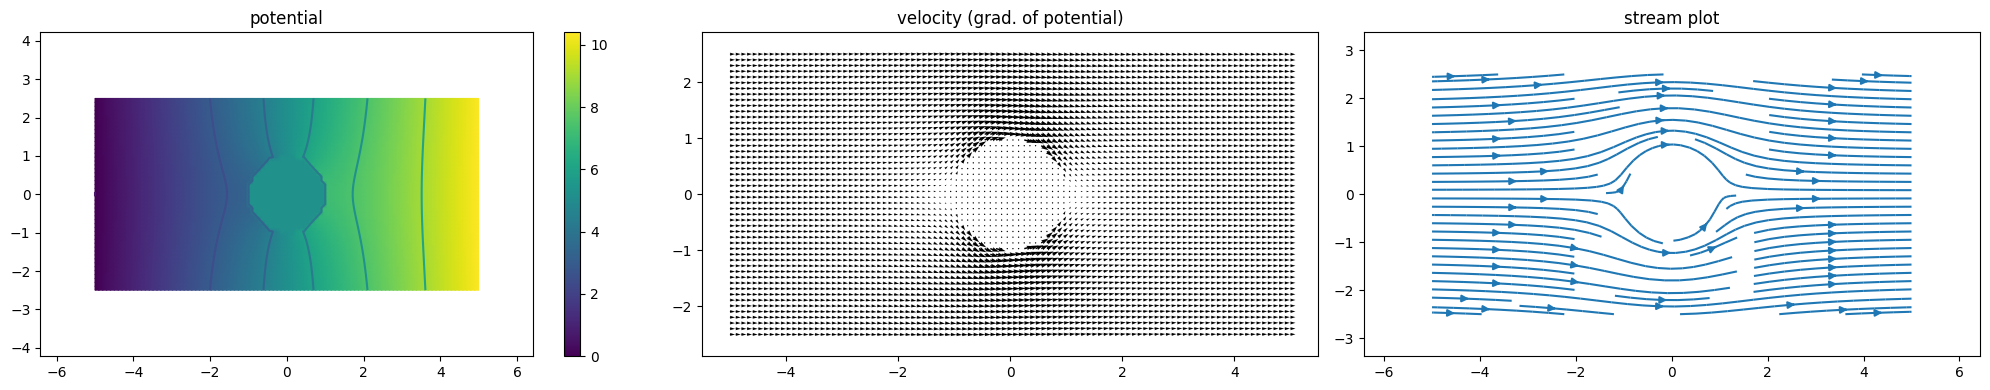

In [7]:
phi_exact, v_x_exact, v_y_exact = compute_analytical_solution(grid, U=1, R=cylinder_radius)

make_plot(phi_exact, grid, uv=(v_x_exact, v_y_exact))

In [8]:
# define network architecture

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )

    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )
    for layer in self.hidden:
      if isinstance(layer, nn.Linear):
        init.xavier_uniform_(layer.weight)

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x

In [10]:
# grid_points_xys = torch.stack((torch.tensor(channel_with_cylinder_xs, dtype=torch.float32).flatten(), torch.tensor(channel_with_cylinder_ys, dtype=torch.float32).flatten()), 0)
grid_points_xys = torch.stack((torch.tensor(xs, dtype=torch.float32).flatten(), torch.tensor(ys, dtype=torch.float32).flatten()), 1).requires_grad_(True)

inlet_indices = np.where(grid_points_xys[:, 0] == -grid_length_x/2)

outlet_indices = np.where(grid_points_xys[:, 0] == grid_length_x/2)

upper_wall_indices = np.where(grid_points_xys[:, 1] == grid_length_y/2)
lower_wall_indices = np.where(grid_points_xys[:, 1] == -grid_length_y/2)

print(upper_wall_indices)
print(outlet_indices)


(array([4900, 4901, 4902, 4903, 4904, 4905, 4906, 4907, 4908, 4909, 4910,
       4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921,
       4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932,
       4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943,
       4944, 4945, 4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954,
       4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962, 4963, 4964, 4965,
       4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976,
       4977, 4978, 4979, 4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987,
       4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998,
       4999]),)
(array([  99,  199,  299,  399,  499,  599,  699,  799,  899,  999, 1099,
       1199, 1299, 1399, 1499, 1599, 1699, 1799, 1899, 1999, 2099, 2199,
       2299, 2399, 2499, 2599, 2699, 2799, 2899, 2999, 3099, 3199, 3299,
       3399, 3499, 3599, 3699, 3799, 3899, 3999, 4099, 4199, 4299, 4399,
       4499, 4599, 4699, 4799, 48

tensor(0.0132, grad_fn=<MeanBackward0>) tensor(1.9131, grad_fn=<MeanBackward0>) tensor(1.0536, grad_fn=<AddBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>)


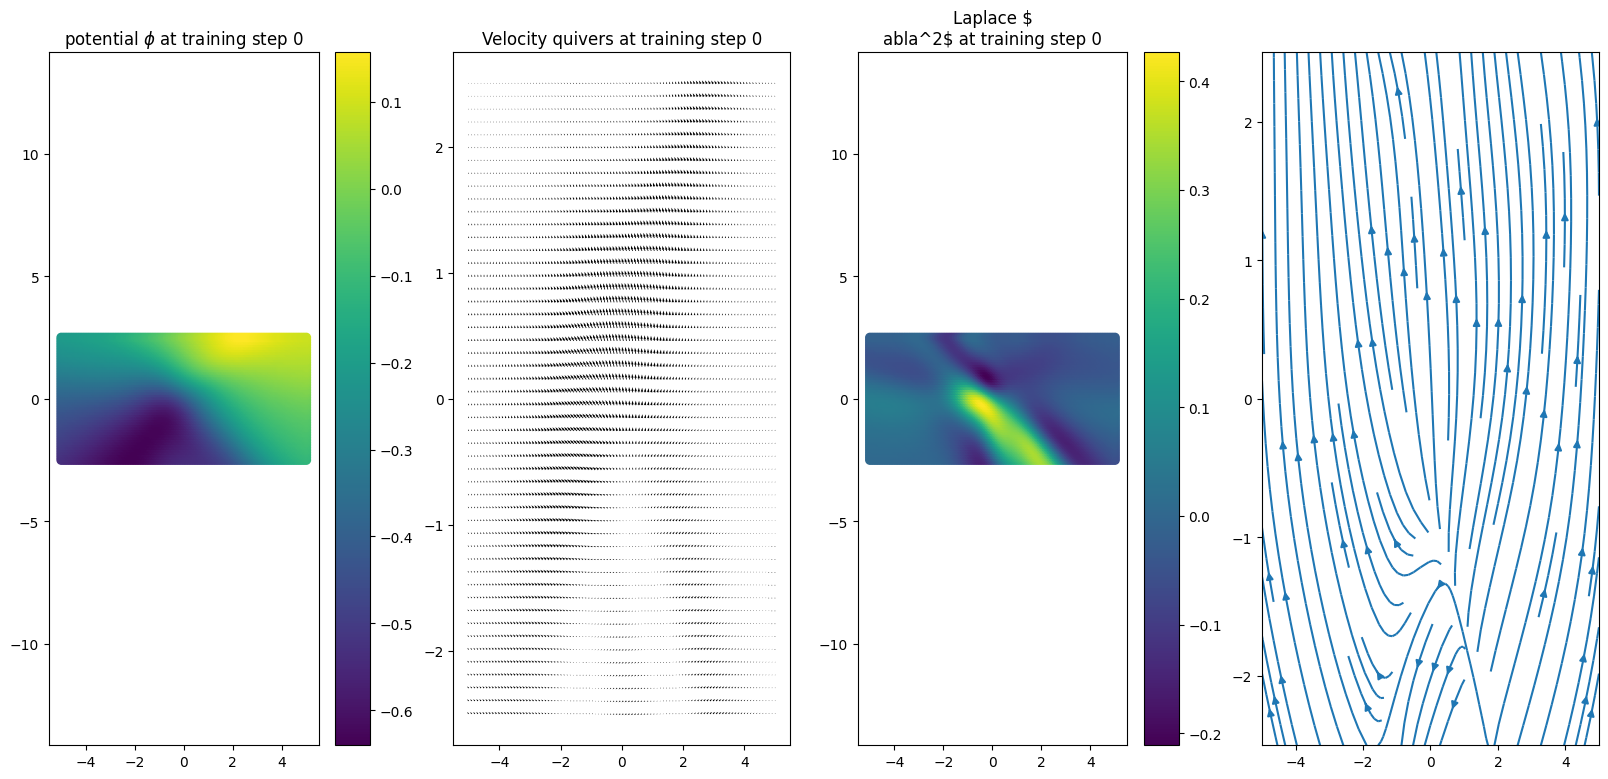

tensor(0.0153, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>) tensor(0.0021, grad_fn=<AddBackward0>) tensor(0.0018, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>)


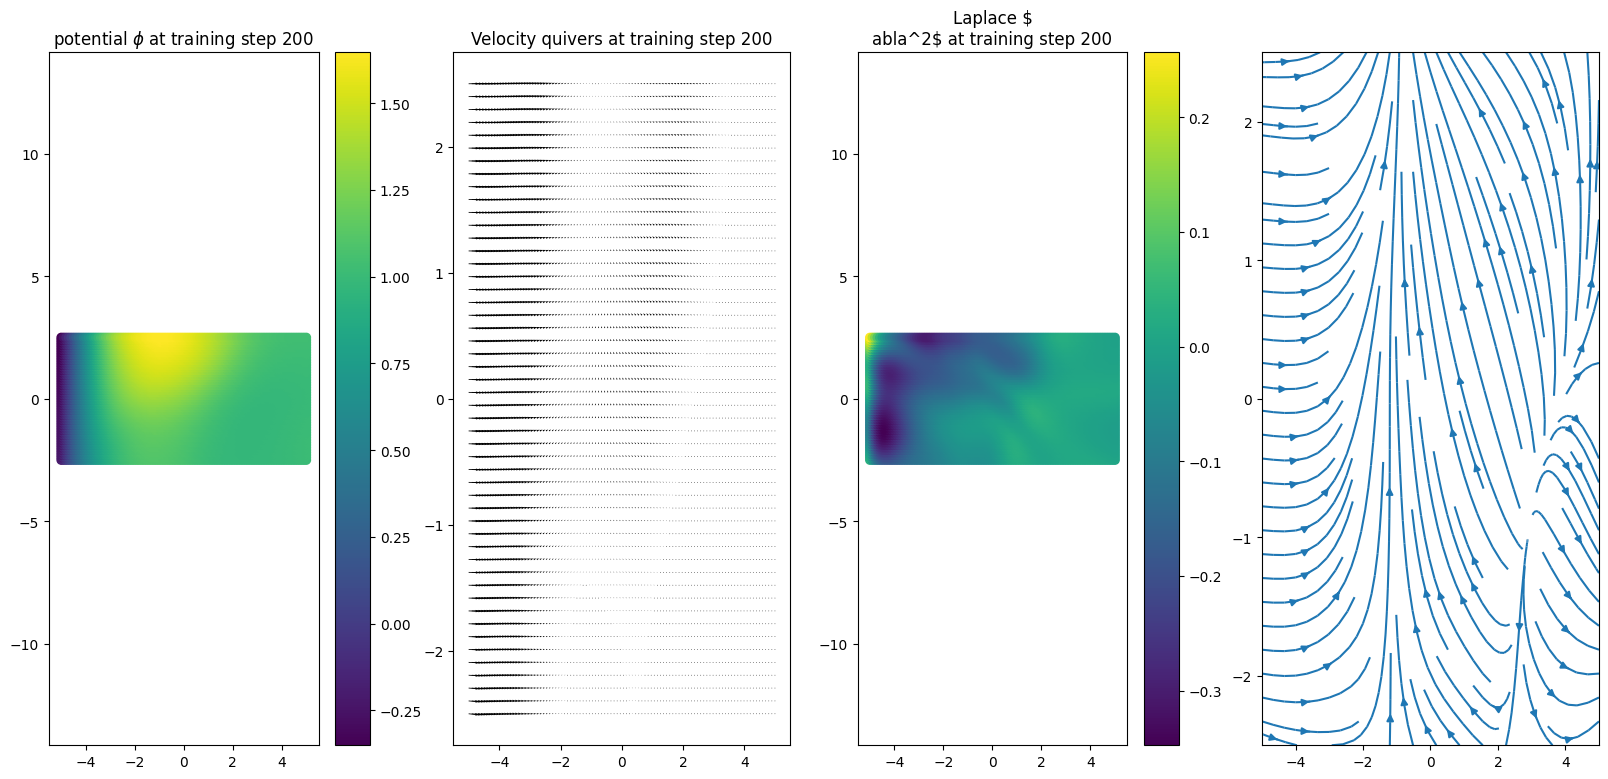

tensor(0.0104, grad_fn=<MeanBackward0>) tensor(5.9710e-05, grad_fn=<MeanBackward0>) tensor(0.0009, grad_fn=<AddBackward0>) tensor(0.0012, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


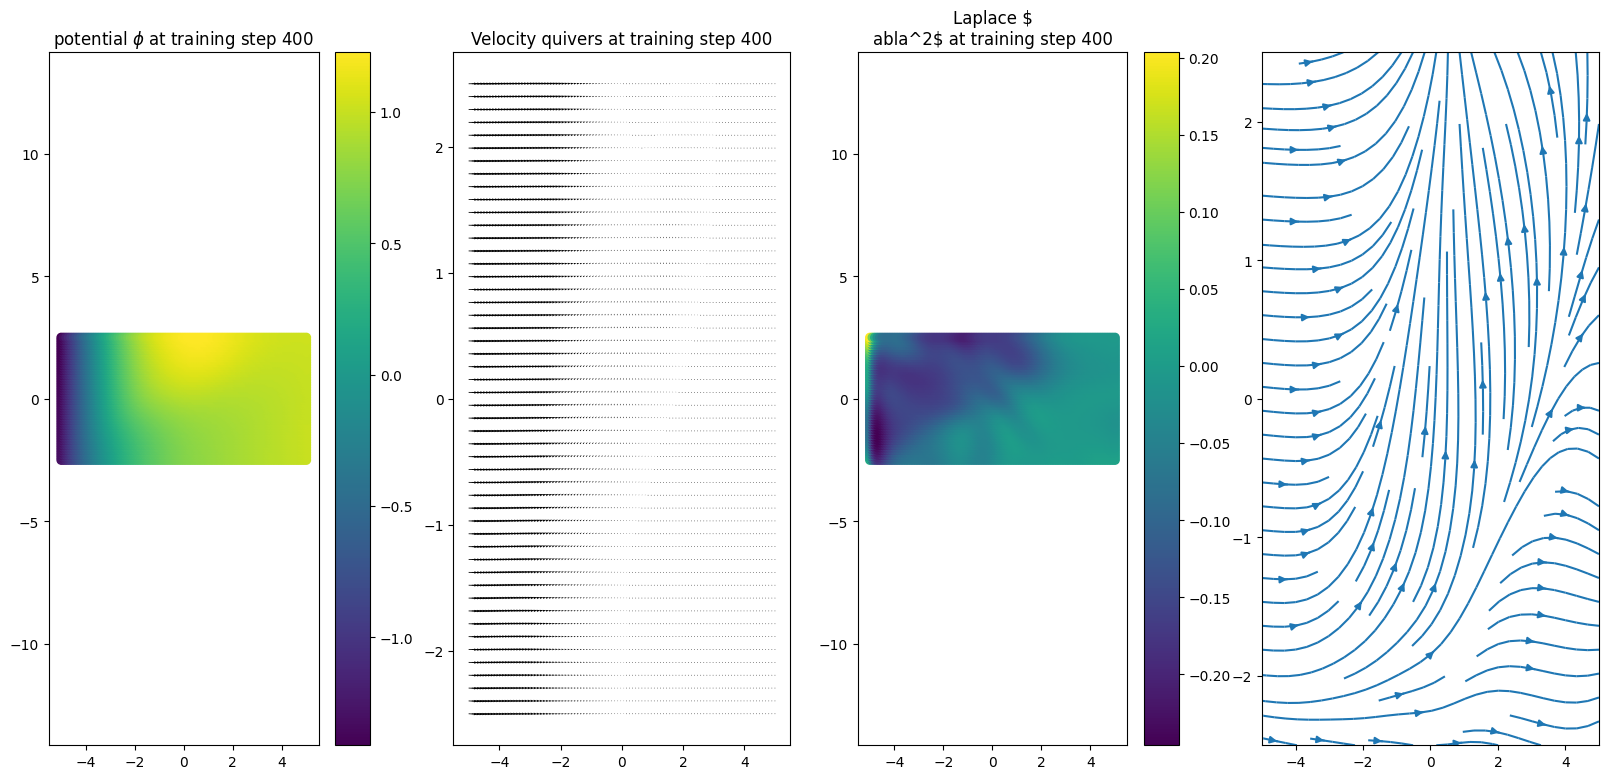

tensor(0.0079, grad_fn=<MeanBackward0>) tensor(4.5416e-05, grad_fn=<MeanBackward0>) tensor(0.0006, grad_fn=<AddBackward0>) tensor(0.0008, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


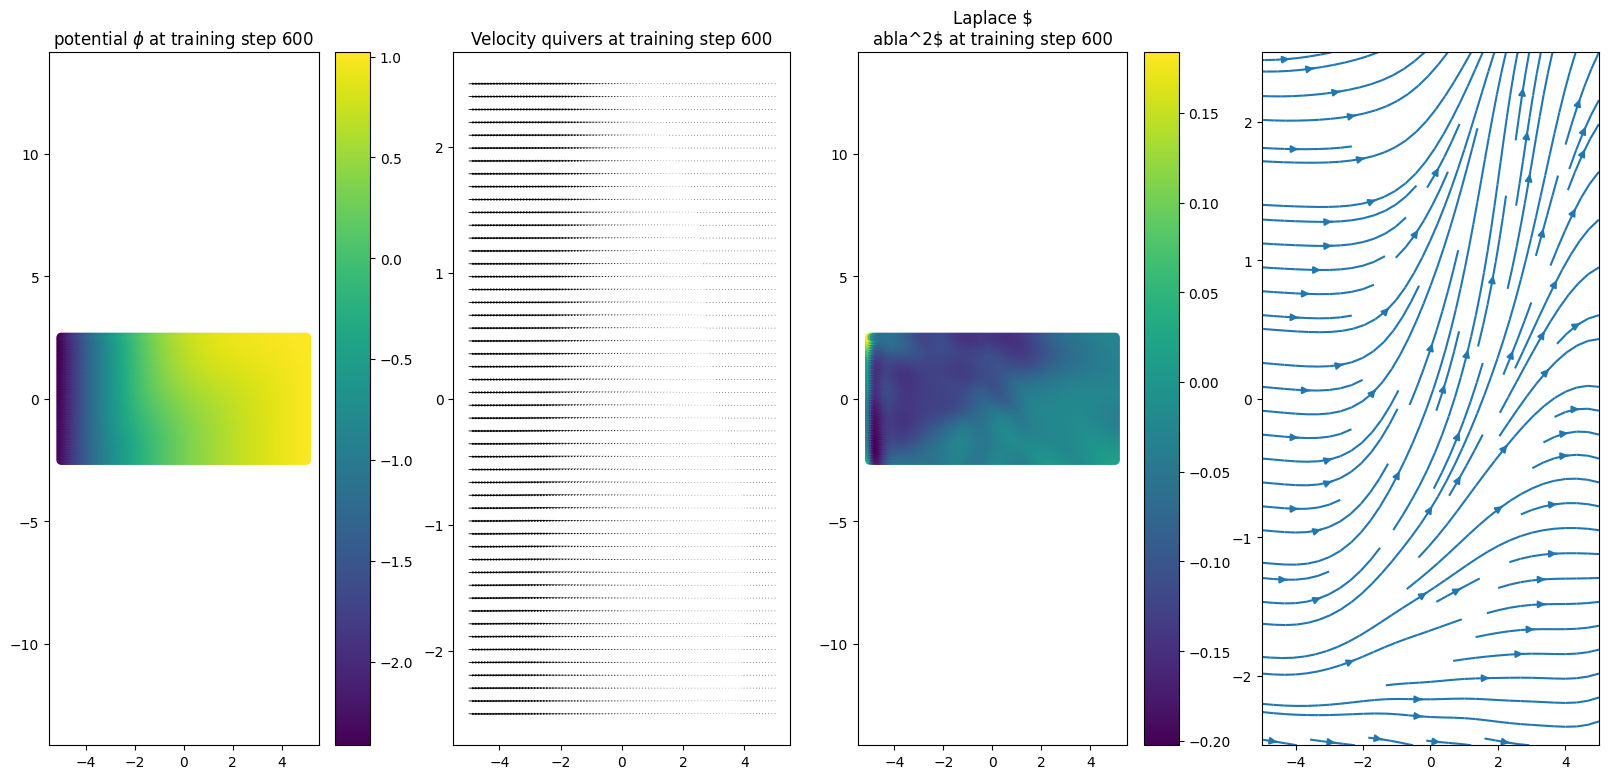

tensor(0.0061, grad_fn=<MeanBackward0>) tensor(4.7008e-05, grad_fn=<MeanBackward0>) tensor(0.0005, grad_fn=<AddBackward0>) tensor(0.0006, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


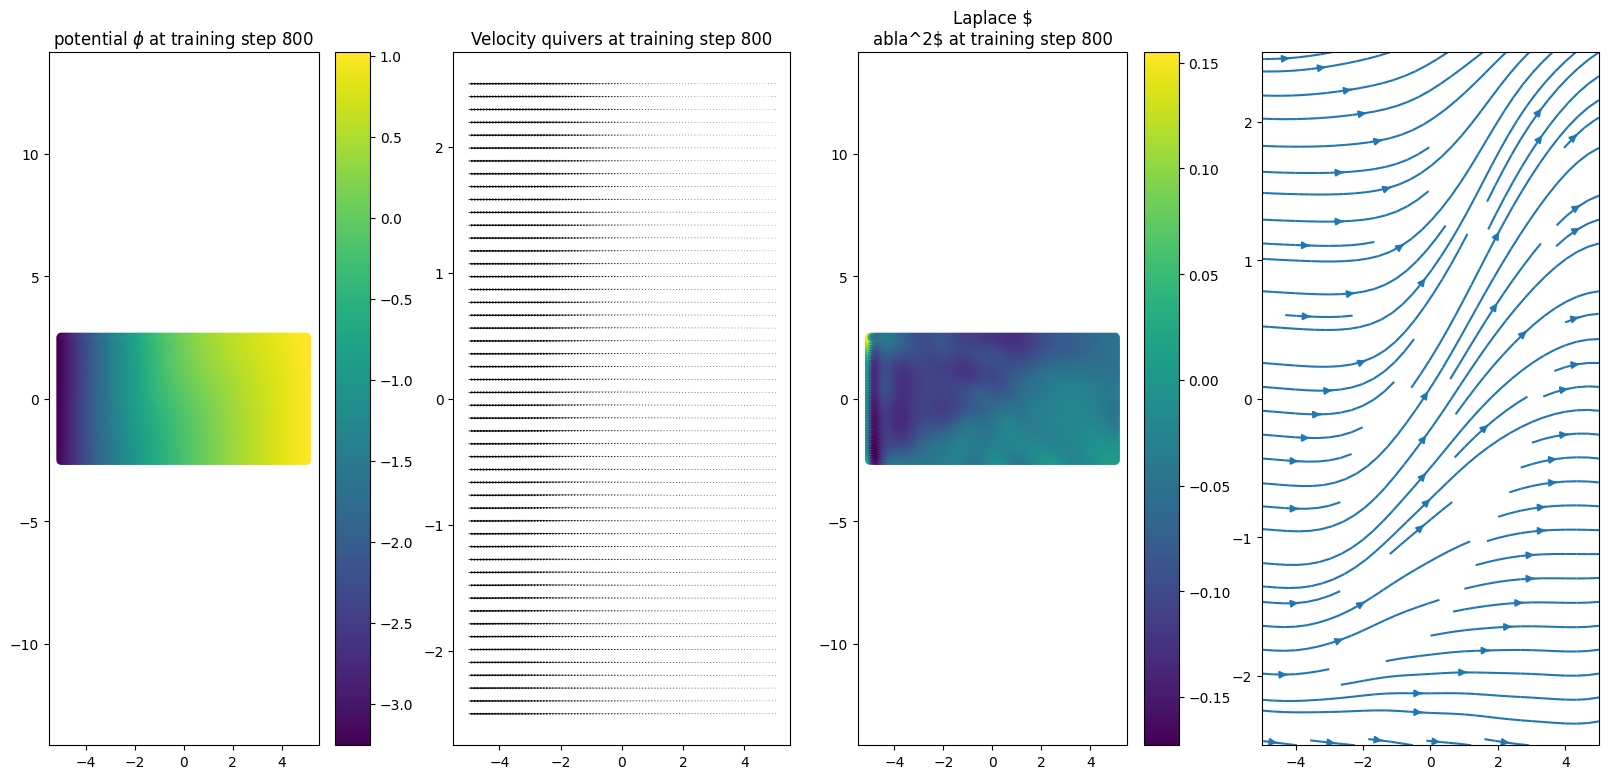

tensor(0.0050, grad_fn=<MeanBackward0>) tensor(5.9139e-05, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<AddBackward0>) tensor(0.0005, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>)


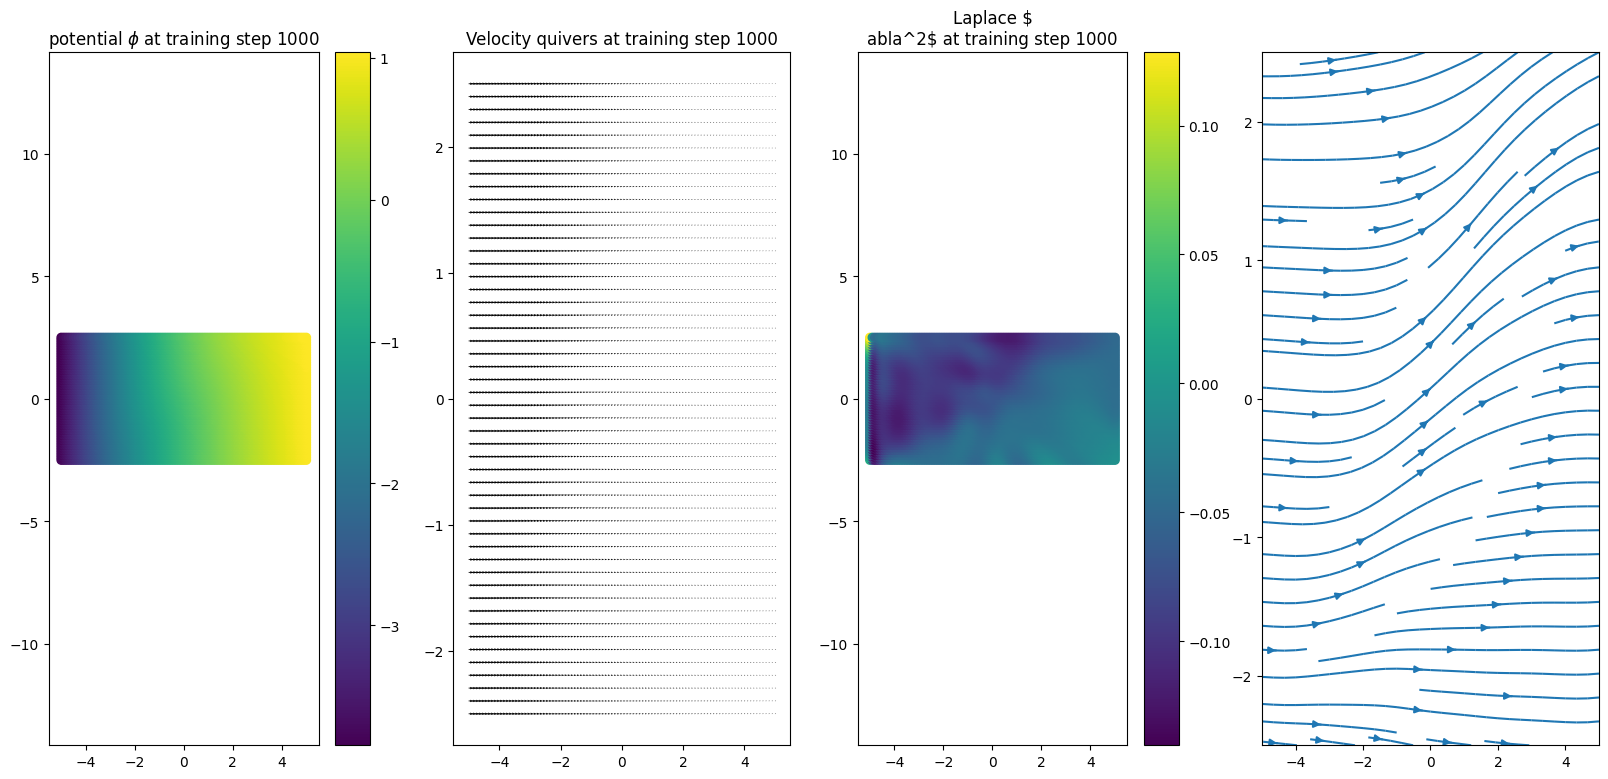

tensor(0.0040, grad_fn=<MeanBackward0>) tensor(3.2254e-05, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>) tensor(9.3031e-05, grad_fn=<MeanBackward0>)


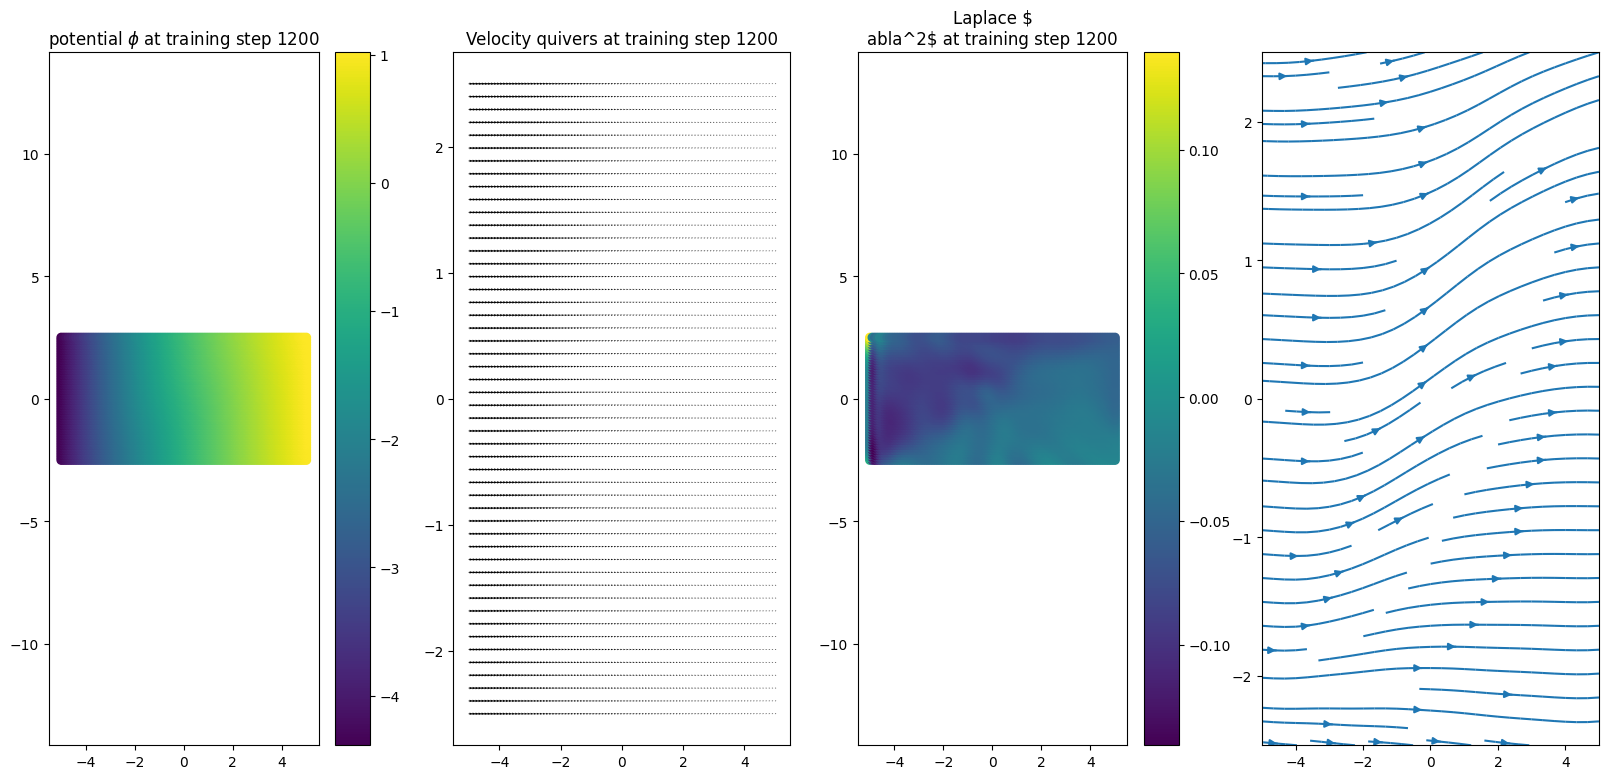

tensor(0.0033, grad_fn=<MeanBackward0>) tensor(2.4891e-05, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<AddBackward0>) tensor(0.0004, grad_fn=<MeanBackward0>) tensor(8.6286e-05, grad_fn=<MeanBackward0>)


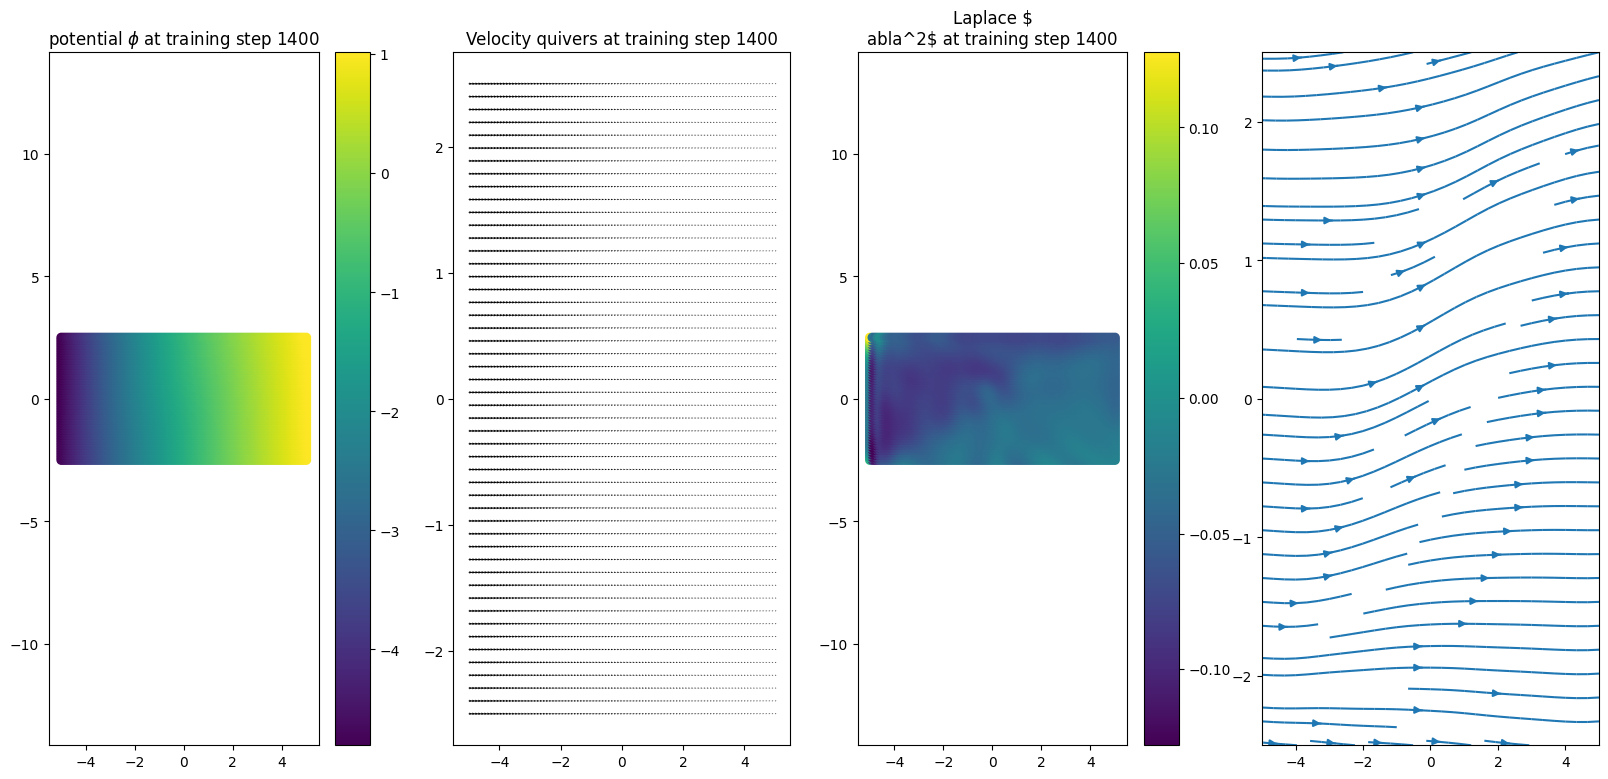

tensor(0.0034, grad_fn=<MeanBackward0>) tensor(0.0013, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<AddBackward0>) tensor(0.0003, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>)


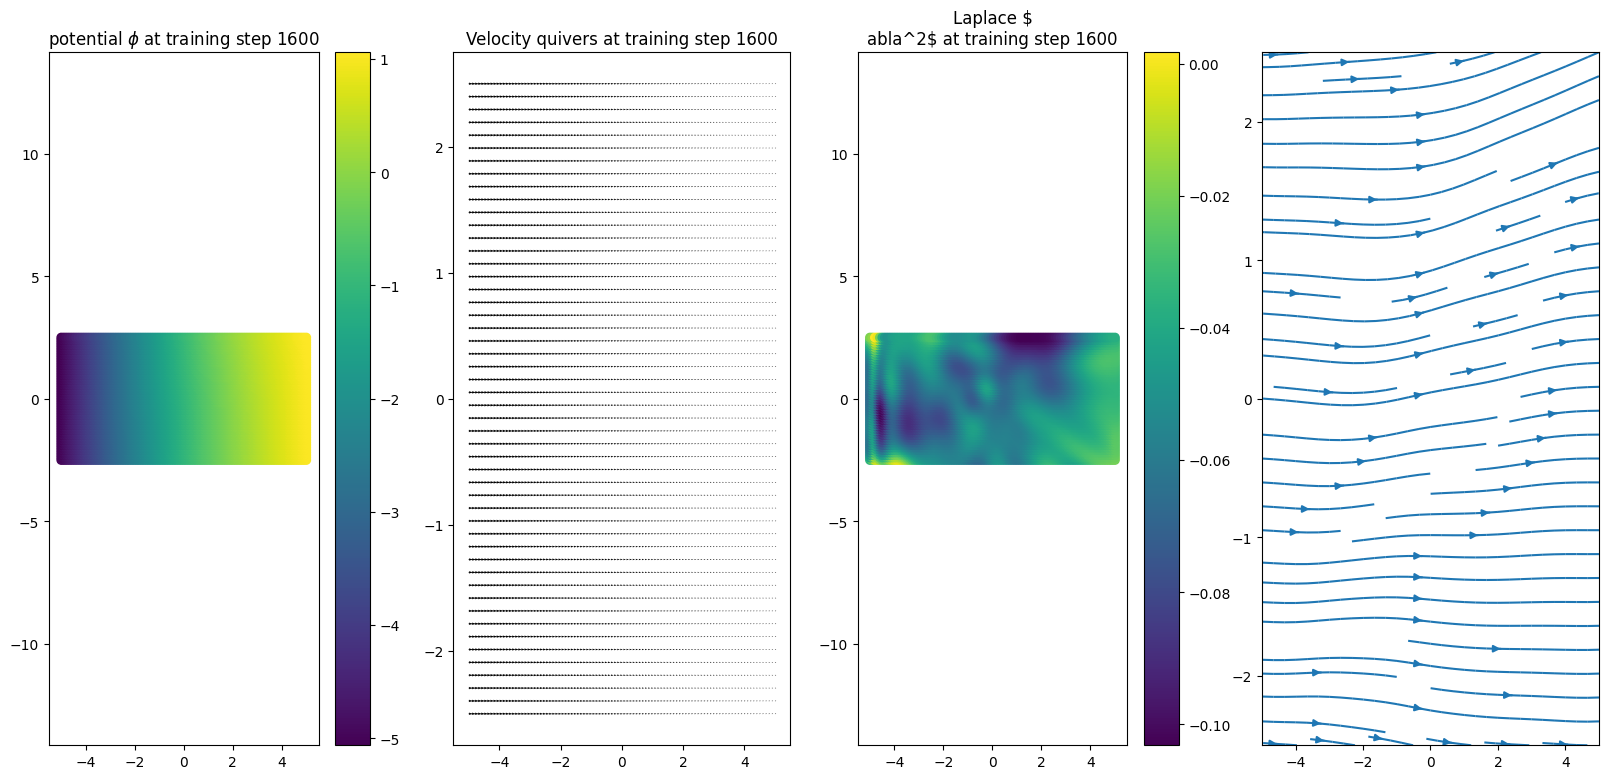

tensor(0.0019, grad_fn=<MeanBackward0>) tensor(8.0092e-06, grad_fn=<MeanBackward0>) tensor(0.0002, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>) tensor(2.1633e-05, grad_fn=<MeanBackward0>)


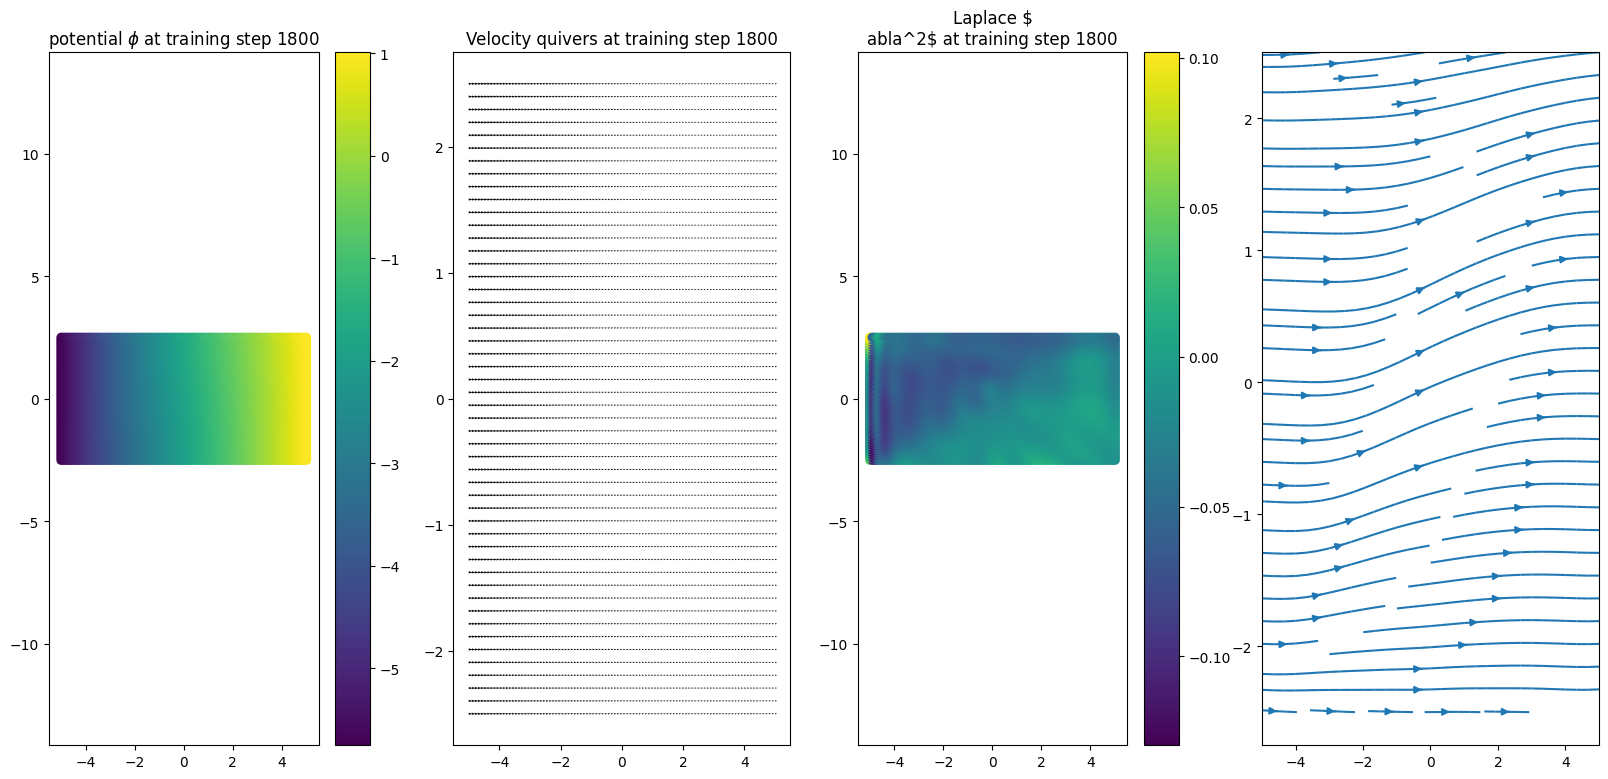

tensor(0.0016, grad_fn=<MeanBackward0>) tensor(7.7924e-06, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>) tensor(2.2591e-05, grad_fn=<MeanBackward0>)


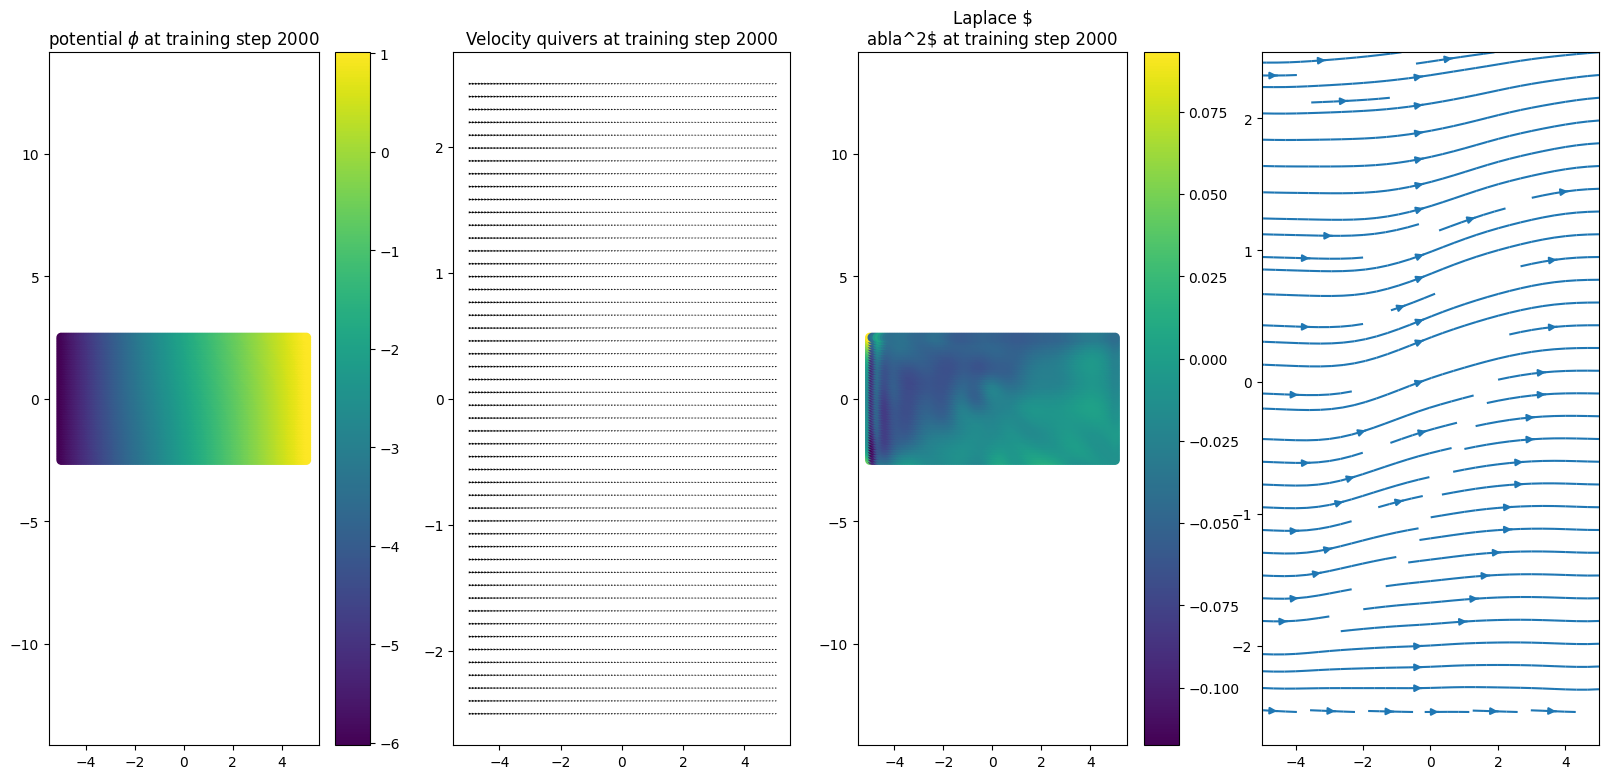

tensor(0.0017, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<MeanBackward0>) tensor(0.0001, grad_fn=<AddBackward0>) tensor(0.0002, grad_fn=<MeanBackward0>) tensor(7.5199e-05, grad_fn=<MeanBackward0>)


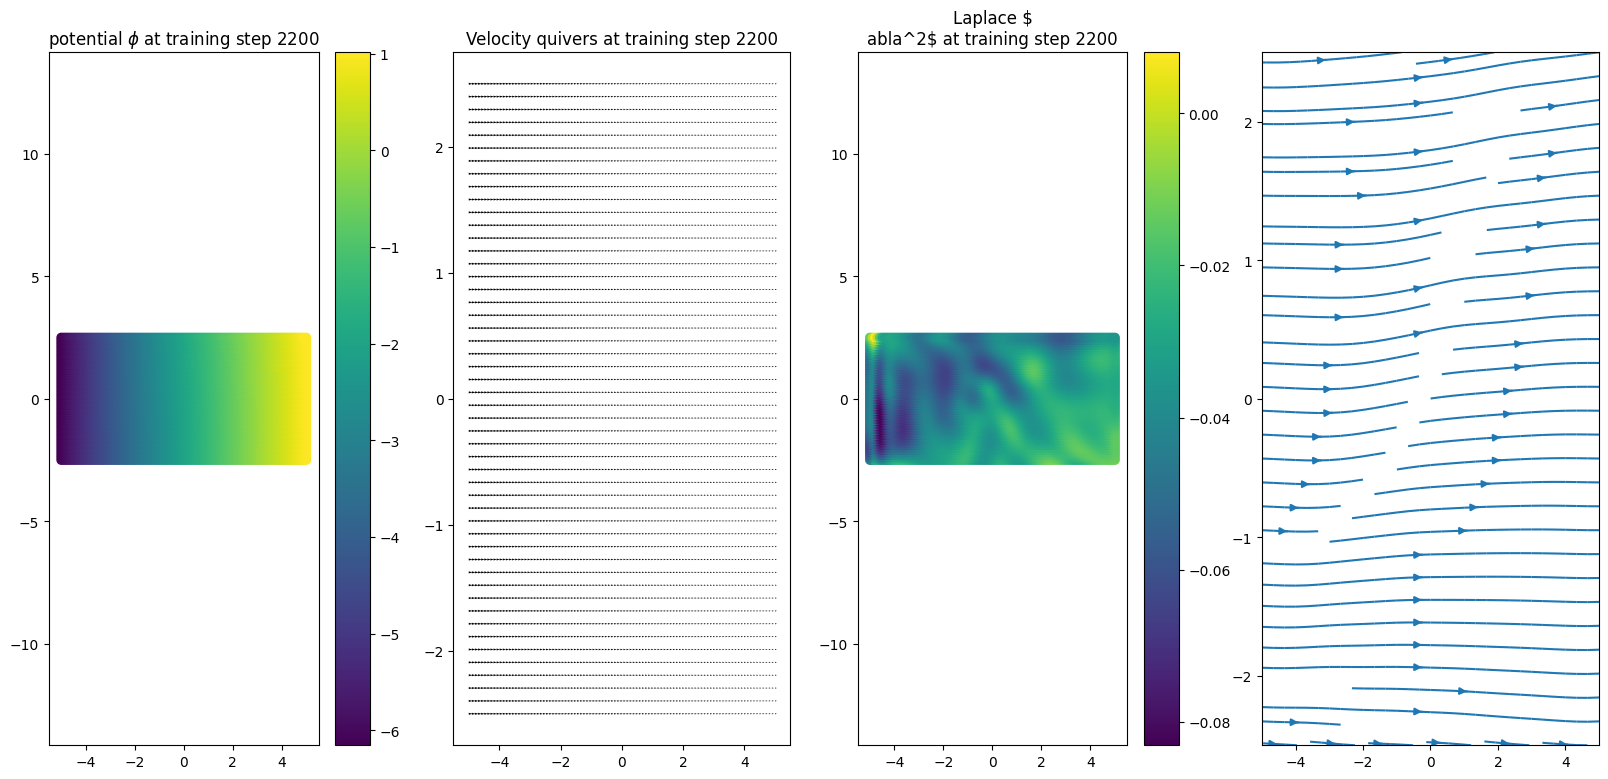

tensor(0.0009, grad_fn=<MeanBackward0>) tensor(7.4837e-06, grad_fn=<MeanBackward0>) tensor(7.5570e-05, grad_fn=<AddBackward0>) tensor(9.8096e-05, grad_fn=<MeanBackward0>) tensor(1.0528e-05, grad_fn=<MeanBackward0>)


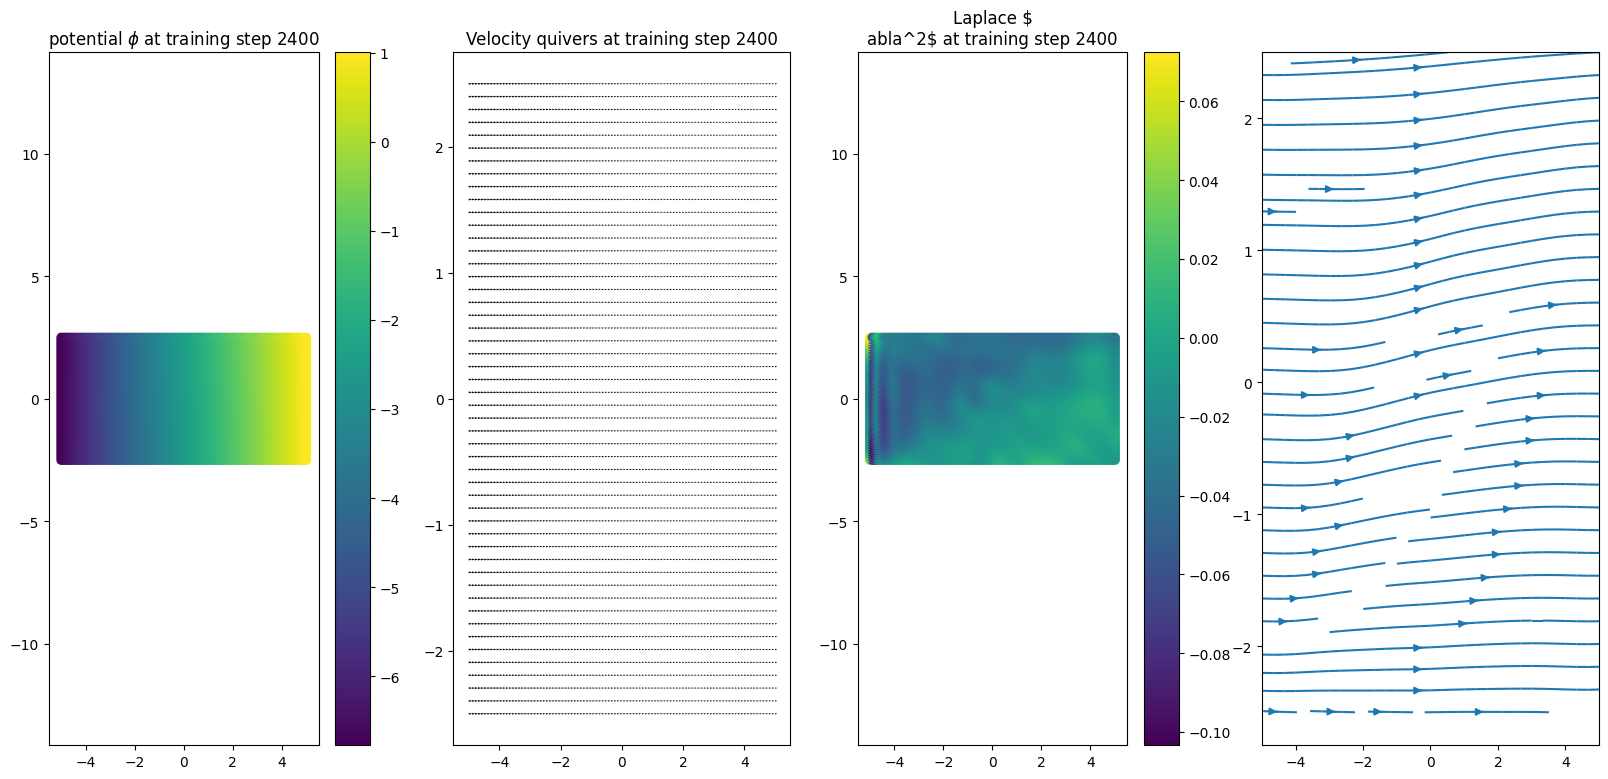

tensor(0.0008, grad_fn=<MeanBackward0>) tensor(4.3699e-06, grad_fn=<MeanBackward0>) tensor(6.2676e-05, grad_fn=<AddBackward0>) tensor(8.3349e-05, grad_fn=<MeanBackward0>) tensor(9.8513e-06, grad_fn=<MeanBackward0>)


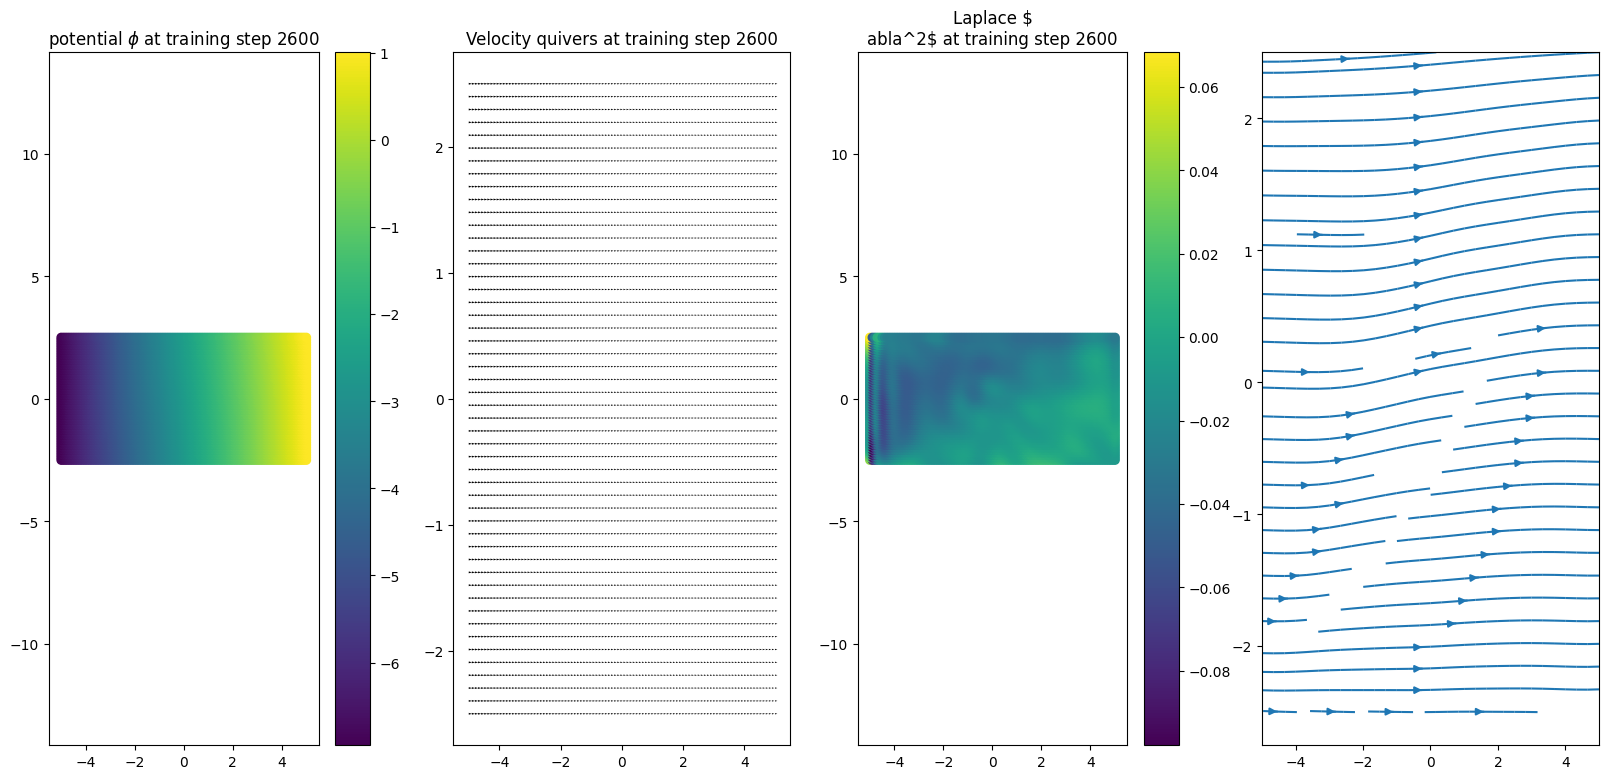

tensor(0.0006, grad_fn=<MeanBackward0>) tensor(4.3949e-06, grad_fn=<MeanBackward0>) tensor(5.2332e-05, grad_fn=<AddBackward0>) tensor(6.8876e-05, grad_fn=<MeanBackward0>) tensor(1.0058e-05, grad_fn=<MeanBackward0>)


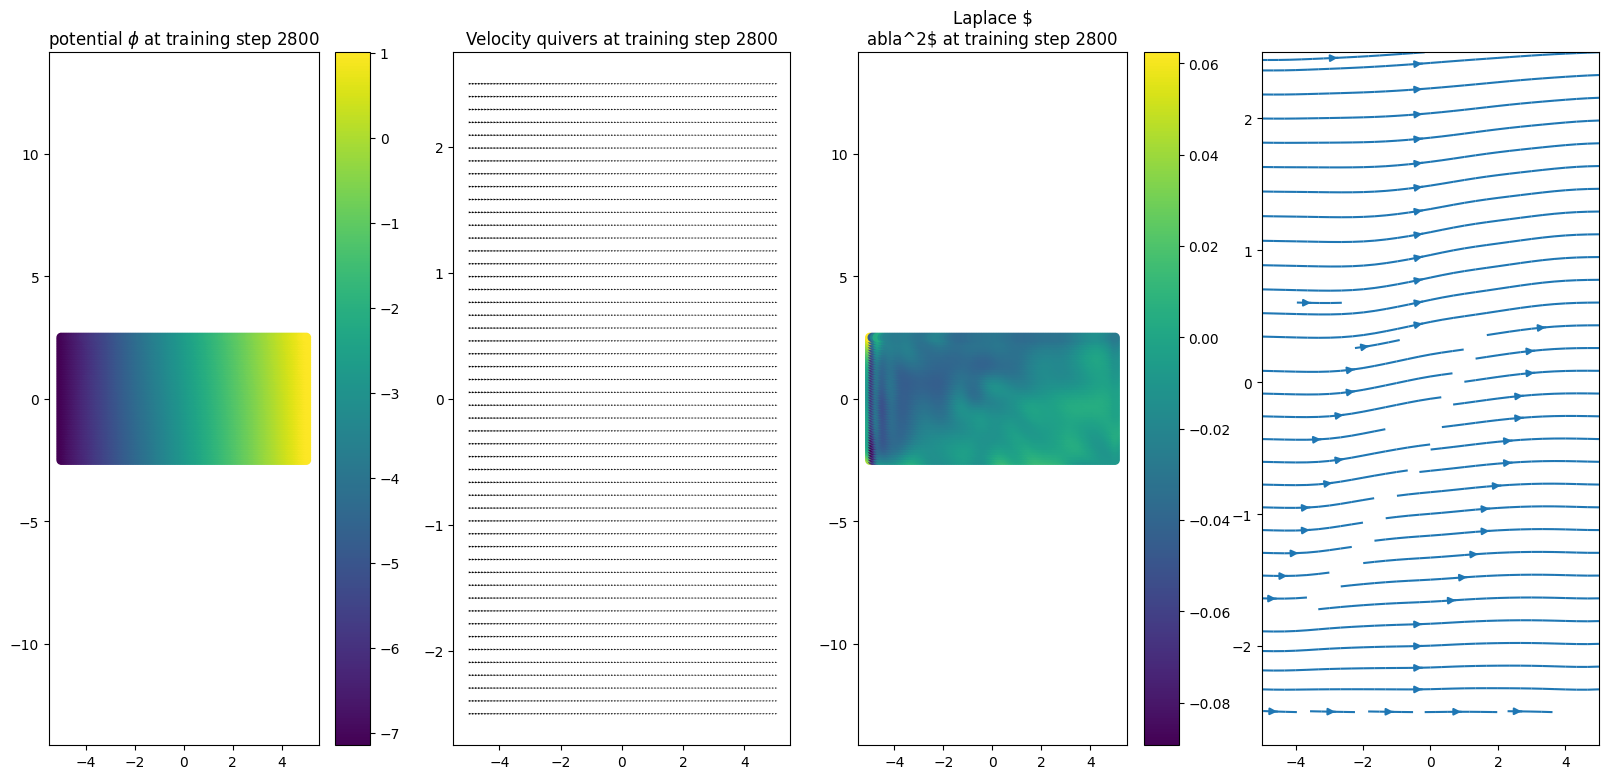

tensor(0.0007, grad_fn=<MeanBackward0>) tensor(7.6544e-05, grad_fn=<MeanBackward0>) tensor(3.6809e-05, grad_fn=<AddBackward0>) tensor(7.0136e-05, grad_fn=<MeanBackward0>) tensor(2.3794e-05, grad_fn=<MeanBackward0>)


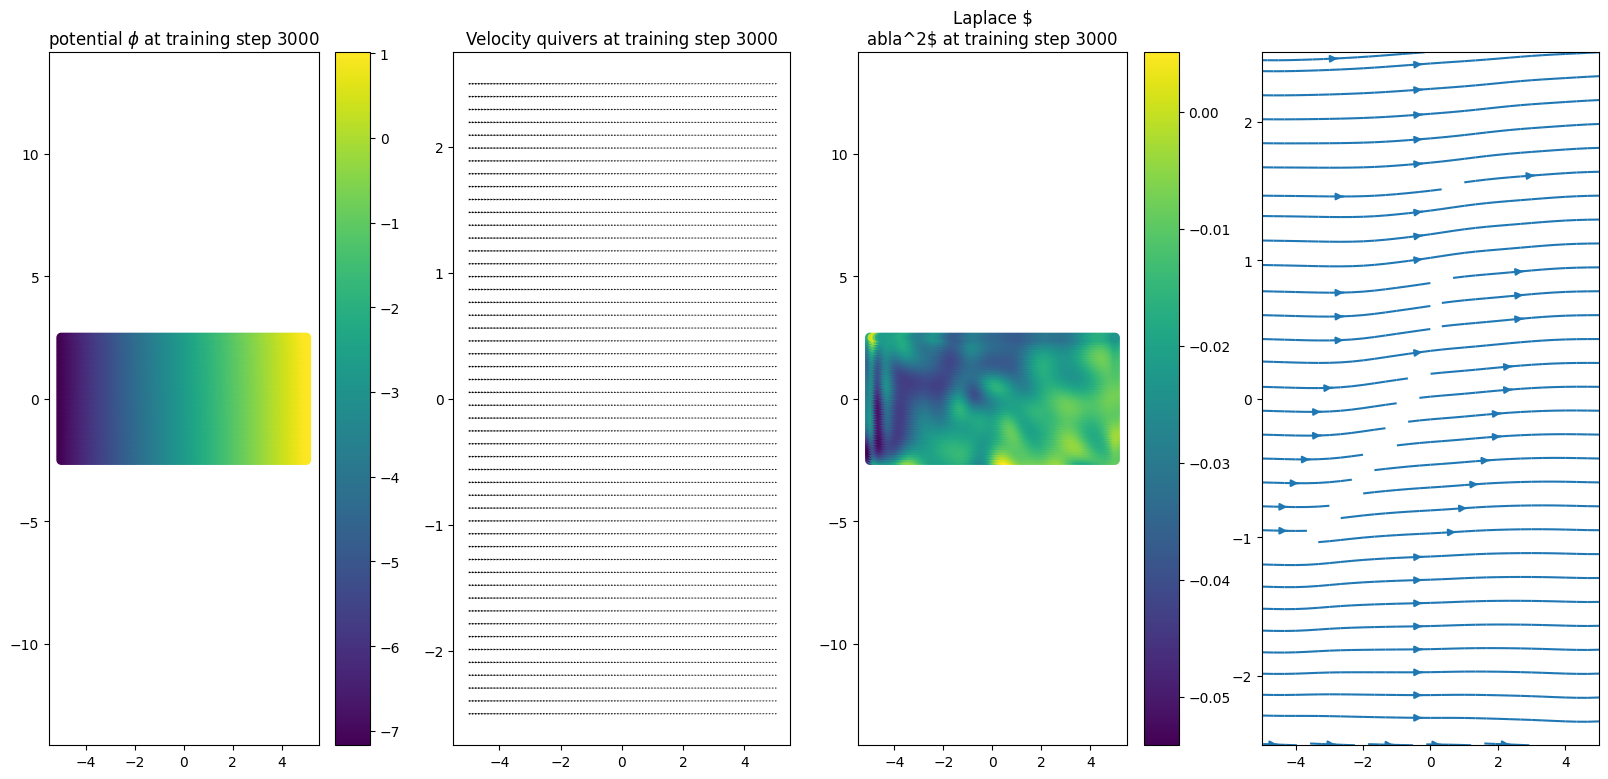

tensor(0.0009, grad_fn=<MeanBackward0>) tensor(0.0017, grad_fn=<MeanBackward0>) tensor(0.0004, grad_fn=<AddBackward0>) tensor(2.5330e-05, grad_fn=<MeanBackward0>) tensor(5.6757e-05, grad_fn=<MeanBackward0>)


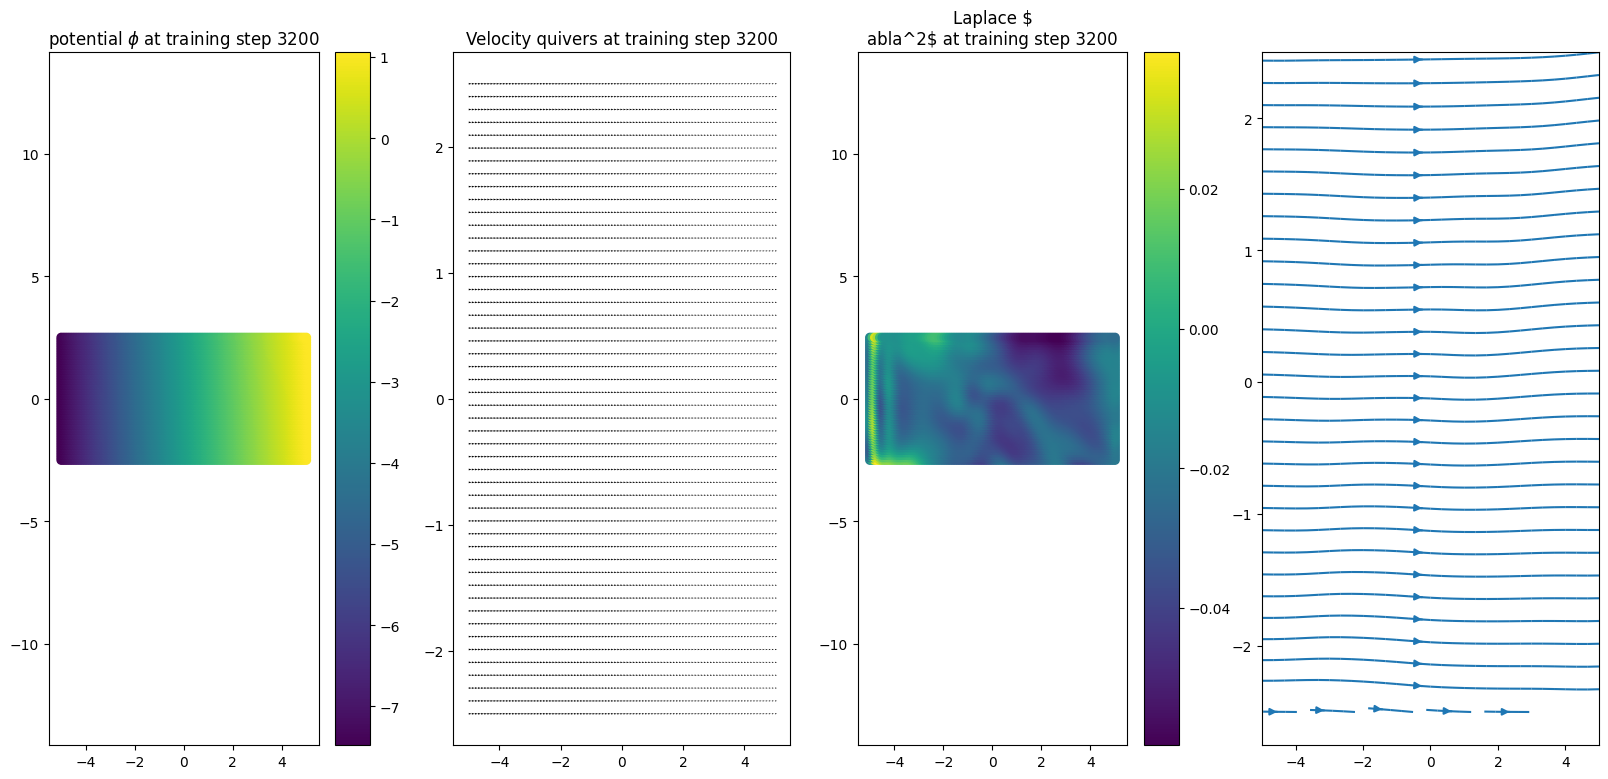

tensor(0.0003, grad_fn=<MeanBackward0>) tensor(2.3020e-06, grad_fn=<MeanBackward0>) tensor(2.2591e-05, grad_fn=<AddBackward0>) tensor(2.9108e-05, grad_fn=<MeanBackward0>) tensor(3.9929e-06, grad_fn=<MeanBackward0>)


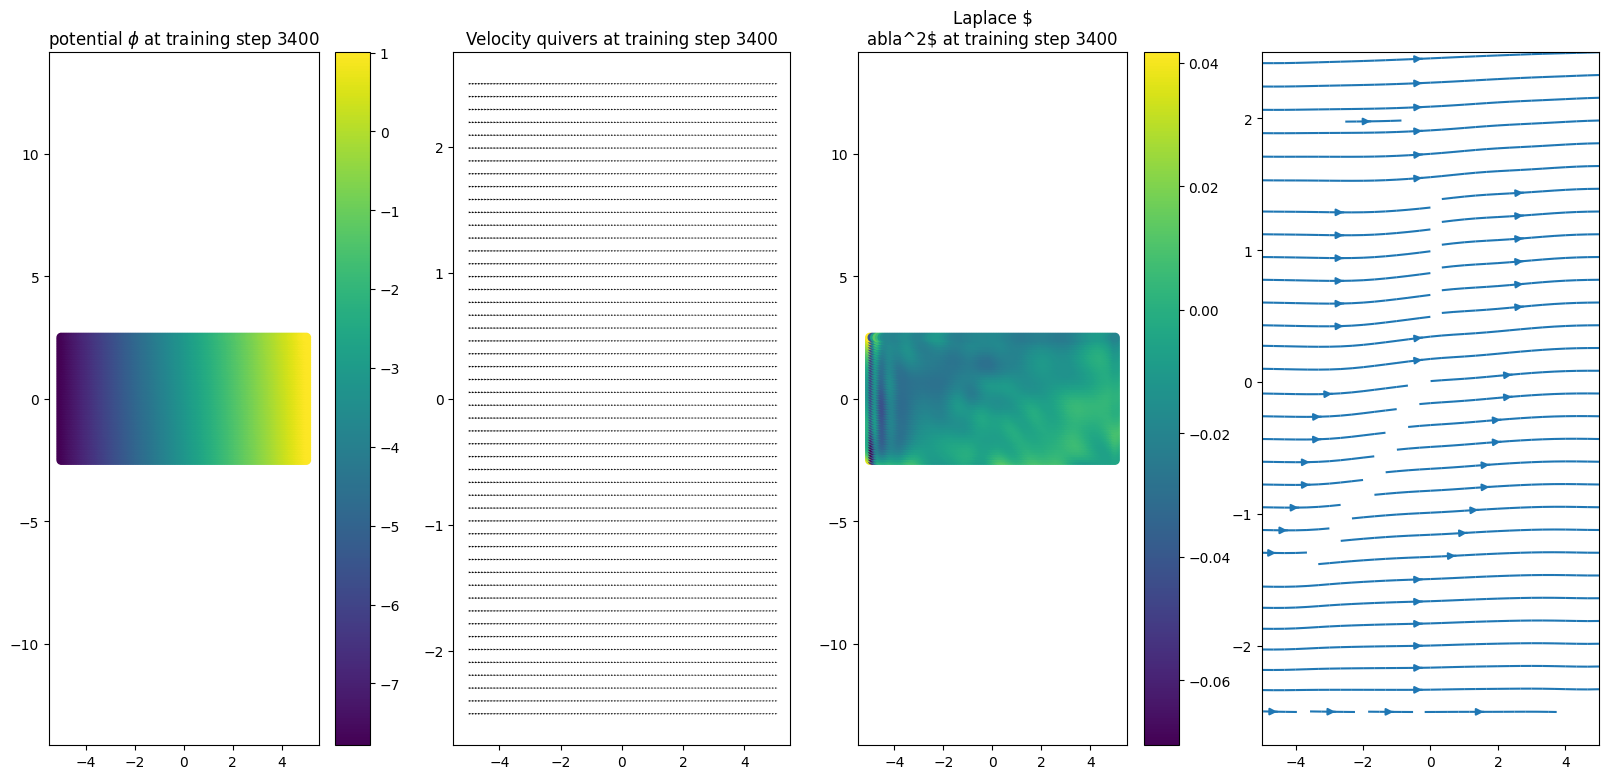

KeyboardInterrupt: ignored

In [19]:
# Define the architecture.
torch.manual_seed(123)

pinn = FullyConnected(2, 64, 1)

# Set optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

nr_steps = 10000

for i in range(nr_steps + 1):
    optimizer.zero_grad()

    # Get model predictions.
    pinn_pred = pinn(grid_points_xys)

    # PDE Laplace loss Compute second order derivative.
    grad_f = torch.autograd.grad(pinn_pred, grid_points_xys, grad_outputs=torch.ones_like(pinn_pred), create_graph=True)[0]
    nabla_f = torch.autograd.grad(grad_f, grid_points_xys, grad_outputs=torch.ones_like(grad_f), create_graph=True)[0]
    residual = torch.sum(nabla_f, 1)
    pde_loss = torch.mean(residual ** 2)

    # Inlet LHS condition grad_phi = 1
    ideal_inlet_velocity_x = torch.ones(50)
    ideal_inlet_velocity_y = torch.zeros(50)

    residual_inlet_x = grad_f[inlet_indices][:, 0] - ideal_inlet_velocity_x
    residual_inlet_y = grad_f[inlet_indices][:, 1] - ideal_inlet_velocity_y
    inlet_loss = torch.mean(residual_inlet_x ** 2) + torch.mean(residual_inlet_y ** 2)

    # Outlet RHS condition phi = 1
    ideal_outlet_phi = torch.ones(50)
    residual_outlet = pinn_pred[outlet_indices] - ideal_outlet_phi
    outlet_loss = torch.mean(residual_outlet ** 2)

    # No flux walls upper
    grad_upper_wall = grad_f[upper_wall_indices]
    upper_wall_normals = torch.tensor([0, 1]).repeat(len(grad_upper_wall)).reshape(100, 2)
    residual_upper_wall = upper_wall_normals * grad_upper_wall
    upper_wall_loss = torch.mean(residual_upper_wall ** 2)

    # No flux walls lower
    grad_lower_wall = grad_f[lower_wall_indices]
    lower_wall_normals = torch.tensor([0, -1]).repeat(len(grad_lower_wall)).reshape(100, 2)
    residual_lower_wall = lower_wall_normals * grad_lower_wall
    lower_wall_loss = torch.mean(residual_lower_wall ** 2)


    # Combine all the loss terms
    loss = pde_loss + inlet_loss + outlet_loss + upper_wall_loss + lower_wall_loss


    loss.backward()
    optimizer.step()

    if i % 200 == 0:
        print(pde_loss, outlet_loss, inlet_loss, upper_wall_loss, lower_wall_loss)
        phi = pinn(grid_points_xys).detach()
        phi_grad = grad_f.detach().numpy()
        xys = grid_points_xys.detach().numpy()
        laplace = residual.detach().numpy()

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,7))
        m = ax1.scatter(xys[:, 0], xys[:, 1], c=phi)
        cbar = plt.colorbar(m, ax=ax1)
        ax1.axis("equal")
        ax1.set_title(f"potential $\phi$ at training step {i}")

        m = ax2.quiver(xys[:, 0], xys[:, 1], phi_grad[:, 0], phi_grad[:, 1])
        # ax2.axis("equal")
        ax2.set_title(f"Velocity quivers at training step {i}")

        n = ax3.scatter(xys[:, 0], xys[:, 1], c=laplace)
        cbar = plt.colorbar(n, ax=ax3)
        ax3.axis("equal")
        ax3.set_title(f"Laplace $\nabla^2$ at training step {i}")

        vx = phi_grad[:, 0].reshape(50, 100)
        vy = phi_grad[:, 1].reshape(50, 100)
        ax4.streamplot(xs, ys, vx, vy)
        plt.show()




In [22]:
print(vy[1])

[-5.1838979e-03 -4.5723245e-03 -3.7469640e-03 -2.6590452e-03
 -1.5136823e-03 -5.3221732e-04  1.7168373e-04  5.9483200e-04
  7.9559535e-04  8.4452331e-04  7.9546124e-04  6.7922473e-04
  5.0938874e-04  2.9399991e-04  4.3116510e-05 -2.2754818e-04
 -4.9663335e-04 -7.4117631e-04 -9.4044209e-04 -1.0799244e-03
 -1.1544079e-03 -1.1688918e-03 -1.1369884e-03 -1.0790452e-03
 -1.0173470e-03 -9.7107142e-04 -9.5365196e-04 -9.6897036e-04
 -1.0112152e-03 -1.0668710e-03 -1.1185035e-03 -1.1495128e-03
 -1.1483207e-03 -1.1117384e-03 -1.0455027e-03 -9.6236914e-04
 -8.7709725e-04 -8.0259144e-04 -7.4388087e-04 -6.9621205e-04
 -6.4498186e-04 -5.6803226e-04 -4.4199824e-04 -2.4731457e-04
  2.5779009e-05  3.7509203e-04  7.8527629e-04  1.2304336e-03
  1.6794354e-03  2.0988882e-03  2.4594069e-03  2.7371496e-03
  2.9158592e-03  2.9879510e-03  2.9544085e-03  2.8236955e-03
  2.6130974e-03  2.3455173e-03  2.0492226e-03  1.7536730e-03
  1.4875233e-03  1.2735724e-03  1.1272877e-03  1.0531396e-03
  1.0466427e-03  1.09474